# Guitar tuner experiment 3

This experiment tries improve on the estimator created in Experiment2 by clustering the group of maxes found

In [1]:
import warnings

import numpy as np
from scipy.fftpack import rfft
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.cluster.vq import whiten, kmeans2, vq
from sklearn.cluster import KMeans

import fftlib

In [2]:
SOUNDS = [
    ("mi82.4", 82.41, "sounds/guitar/082.4_mi_1.wav"),
    ("la110", 110, "sounds/guitar/110_la_1.wav"),
    ("re146.8", 146.8, "sounds/guitar/146.8_re_1.wav"),
    ("sol196", 196, "sounds/guitar/196_sol_1.wav"),
    ("si246.9", 246.9, "sounds/guitar/246.9_si_1.wav"),
    ("mi329.6", 329.6, "sounds/guitar/329.6_mi_1.wav"),
]
_ = [
    ("mi82.4", 82.41, "sounds/guitar/082.4_mi_2.wav"),
    ("la110", 110, "sounds/guitar/110_la_2.wav"),
    ("re146.8", 146.8, "sounds/guitar/146.8_re_2.wav"),
    ("sol196", 196, "sounds/guitar/196_sol_2.wav"),
    ("si246.9", 246.9, "sounds/guitar/246.9_si_2.wav"),
    ("mi329.6", 329.6, "sounds/guitar/329.6_mi_2.wav"),
]

SAMPLE_DUR = 200. / 1000.


# Creates [(rate, data), ...]:
WAVES = [wavfile.read(filename) for _, _, filename in SOUNDS]
DURATIONS = [len(data)/rate for rate, data in WAVES]

SAMPLES = [
    fftlib.sampling(rate, data.T, SAMPLE_DUR)
    for (rate, data) in WAVES
]

/usr/local/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [3]:
fourier_samples = [[] for _ in SOUNDS]
frequencies = [None for _ in SOUNDS]

for i, sound in enumerate(SAMPLES):
    for j, sample in enumerate(sound):
        frequencies[i], amp = fftlib.analysis(WAVES[i][0], sample)
        fourier_samples[i].append(amp)

We have now `fourier_samples` which is a list of fourier transformations for each sample for each sound and `frequencies` which is a list of x-axis frequencies for each  sound

# First test: try with a fixed or predeterminated number of clusters

Will try to create clusters of maximums by minimizing the standard variation of each cluster.

Note: 82.41


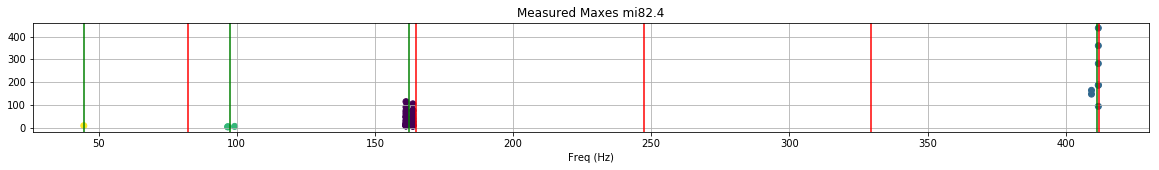

Note: 110


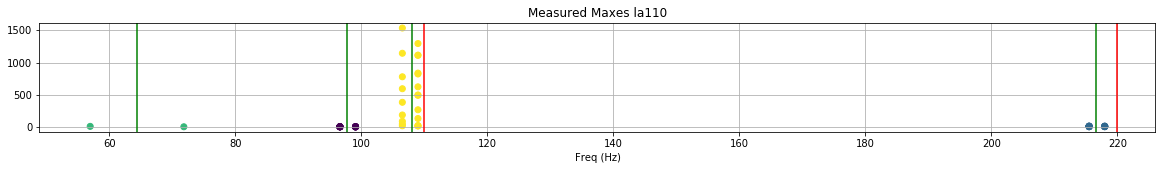

Note: 146.8


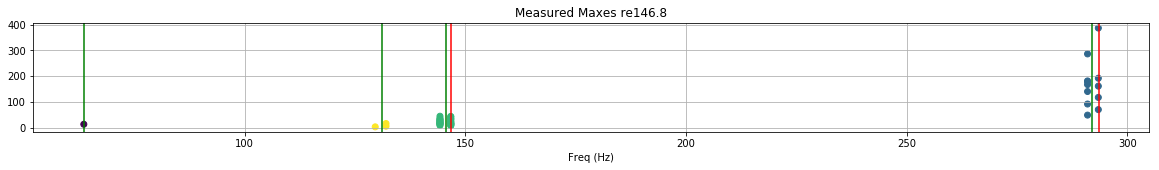

Note: 196


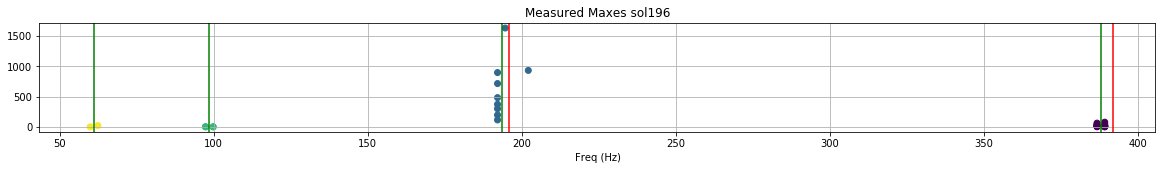

Note: 246.9


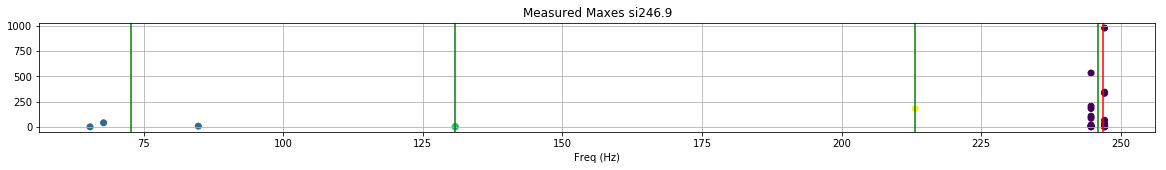

Note: 329.6


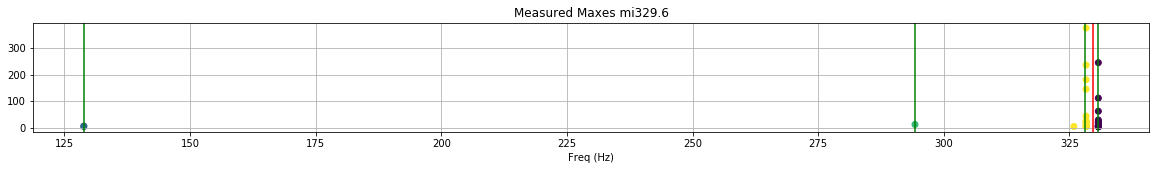

In [4]:
matplotlib.rcParams['figure.figsize'] = (20.0, 2.0)

N_CLUSTERS = 4
for fourier, freq, sound in zip(fourier_samples, frequencies, SOUNDS):
    print(f"Note: {sound[1]}")
    maxes = np.array([(freq[np.argmax(amp)], np.max(amp)) for amp in fourier])
    shaped_maxes = maxes.T[0].reshape(-1, 1)
    kmeans = KMeans(
        n_clusters=N_CLUSTERS,
        random_state=0
    ).fit(shaped_maxes)
    centers = kmeans.cluster_centers_
    plt.scatter(
        x=maxes.T[0],
        y=maxes.T[1],
        c=kmeans.labels_,
        cmap='viridis',
    )
    
    M = 1
    for center in centers:
        plt.axvline(x=center, color="green")
    while max(maxes.T[0])*1.1 > sound[1]*M:
        plt.axvline(x=sound[1]*M, color="red")
        M += 1
    plt.xlabel("Freq (Hz)")
    plt.title(f"Measured Maxes {sound[0]}")
    plt.grid()
    plt.show()

Determination with the elbow method of the best number of clusters

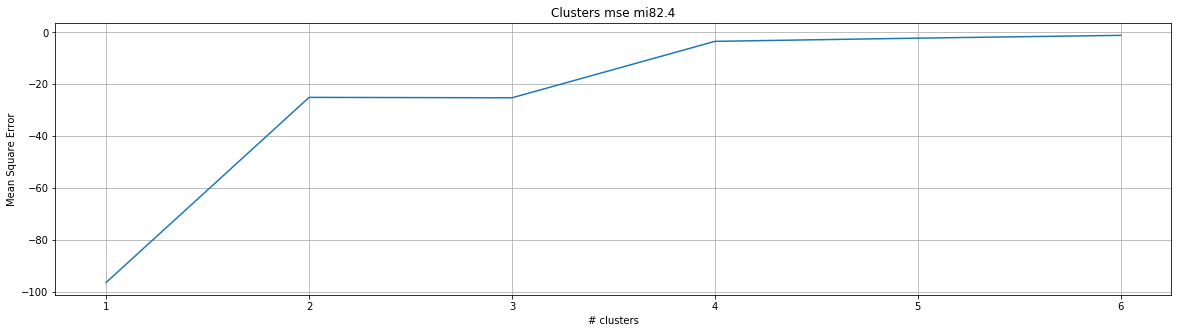

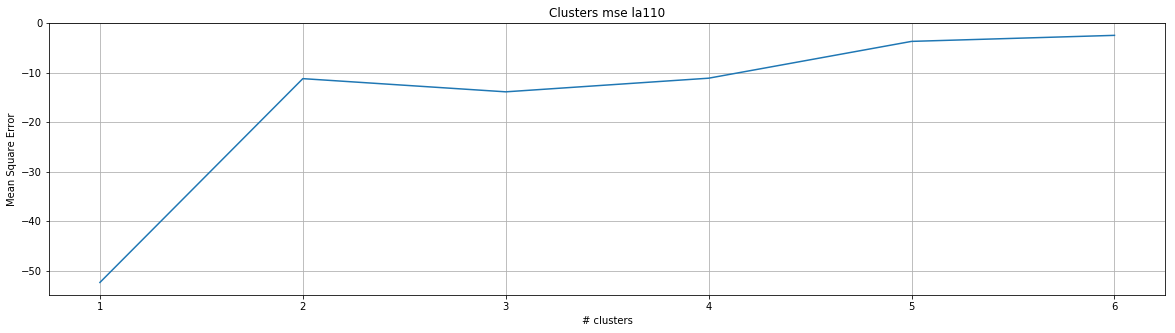

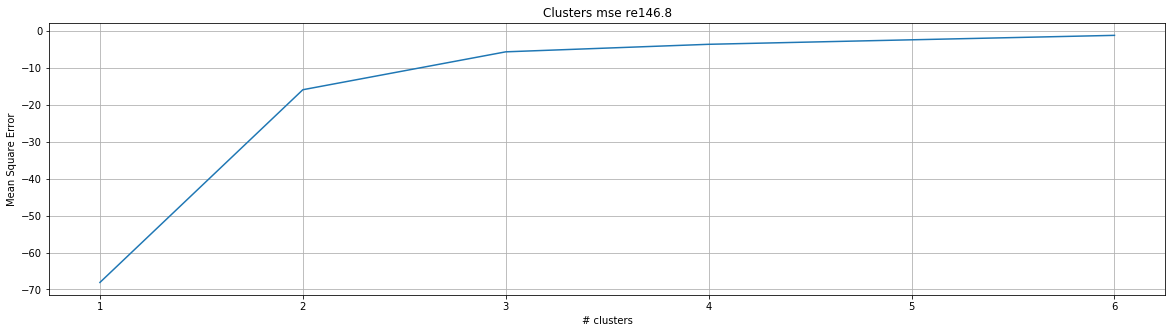

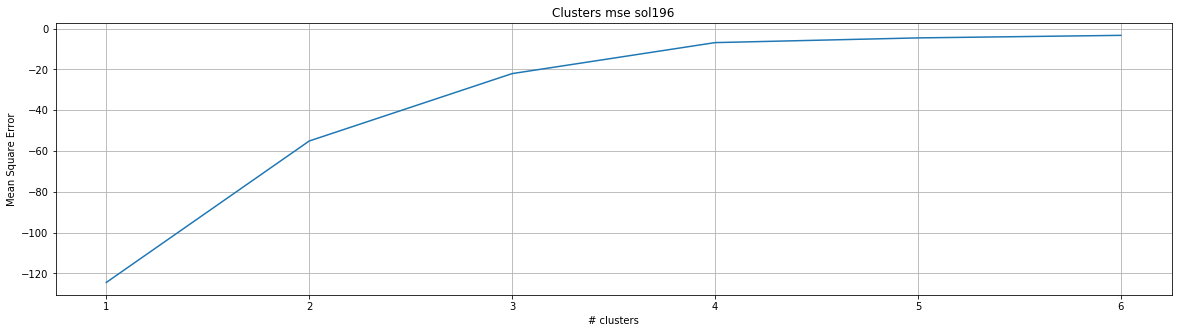

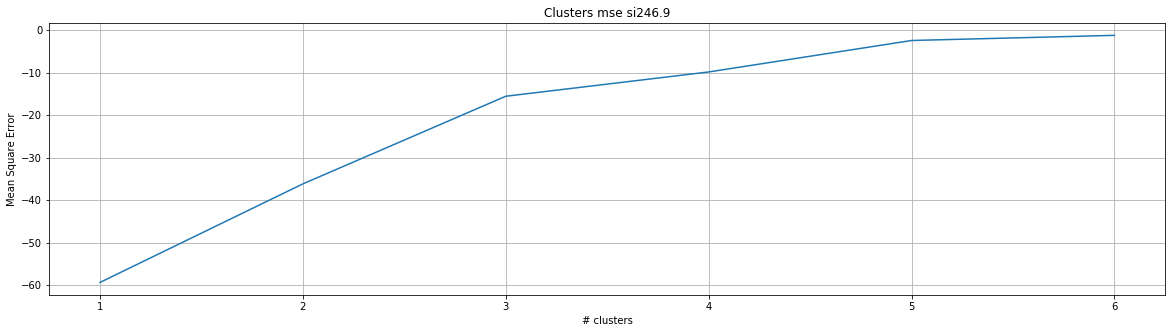

/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)


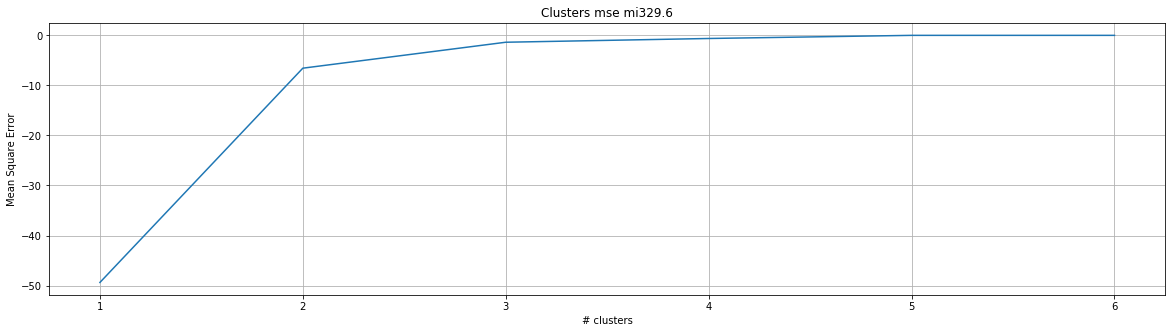

In [5]:
matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)

N_CLUSTERS_MAX = 6
for fourier, freq, sound in zip(fourier_samples, frequencies, SOUNDS):
    maxes = np.array([(freq[np.argmax(amp)], np.max(amp)) for amp in fourier])
    distortion = np.zeros(N_CLUSTERS_MAX)
    for n_clusters in range(1, N_CLUSTERS_MAX + 1):
        shaped_maxes = maxes.T[0].reshape(-1, 1)
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=0
        ).fit(shaped_maxes)
        centers = kmeans.cluster_centers_
        
        clusters_distortion = np.zeros(n_clusters)
        for i in range(n_clusters):
            mask = np.ma.masked_where(kmeans.labels_ != i, maxes.T[0])
            clusters_distortion[i] = mask.std() or 0
        distortion[n_clusters-1] = sum(clusters_distortion)
    plt.plot(
        np.linspace(1, N_CLUSTERS_MAX, N_CLUSTERS_MAX),
        -distortion,
    )

    plt.xlabel("# clusters")
    plt.ylabel("Mean Square Error")
    plt.title(f"Clusters mse {sound[0]}")
    plt.grid()
    plt.show()

Same as previous but removing the smallest points

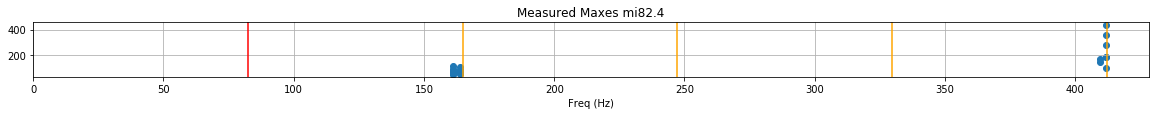

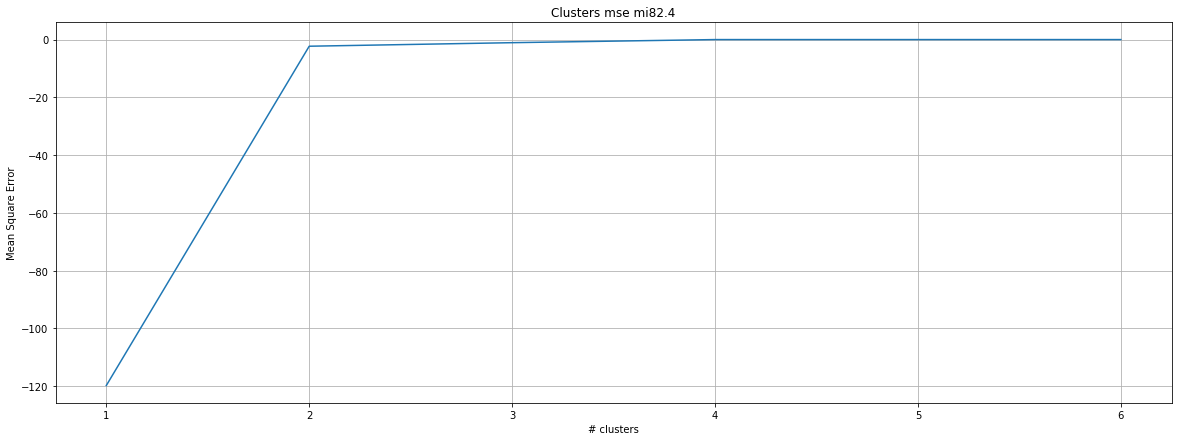

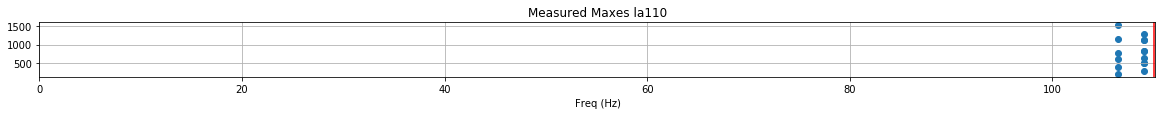

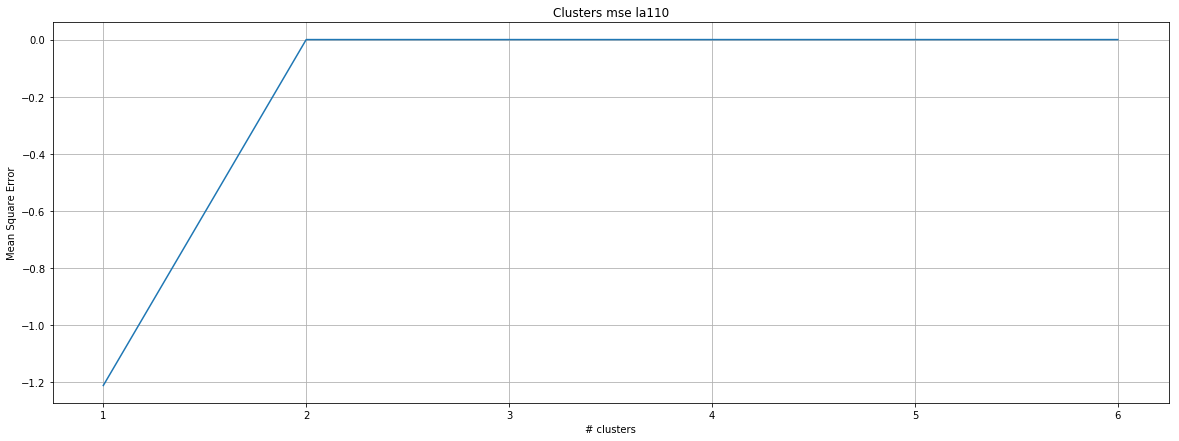

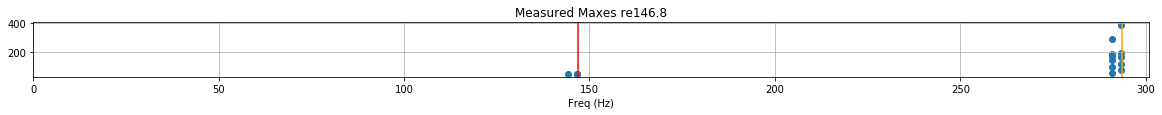

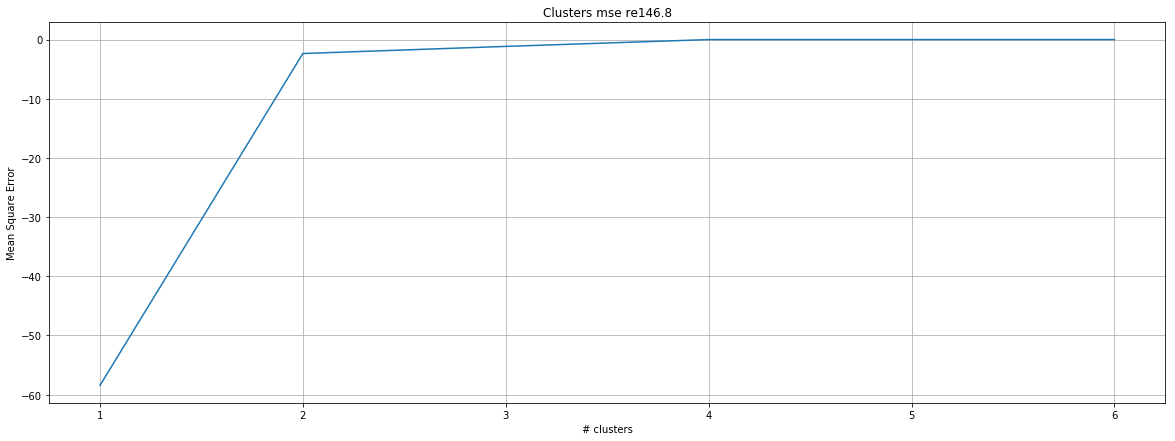

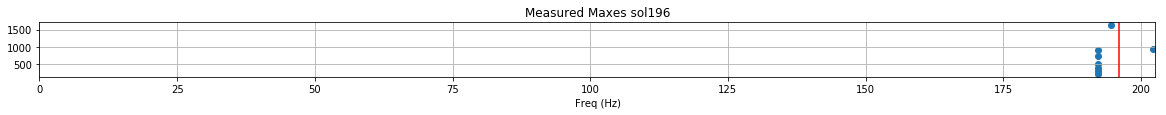

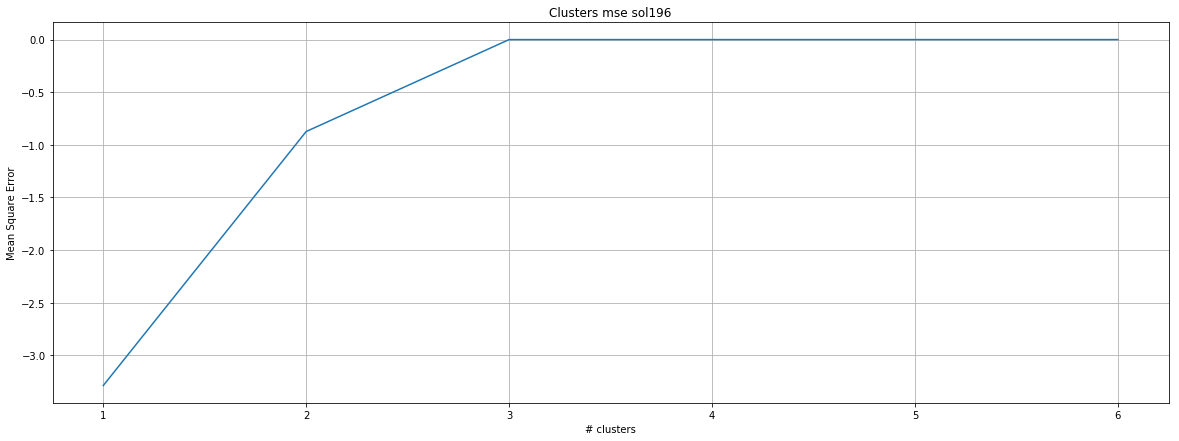

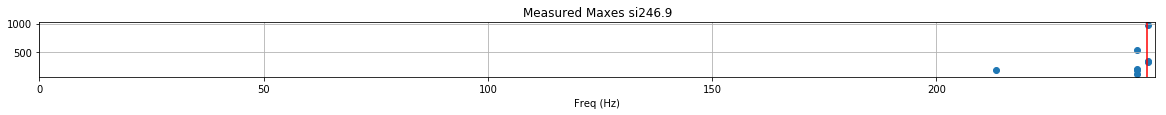

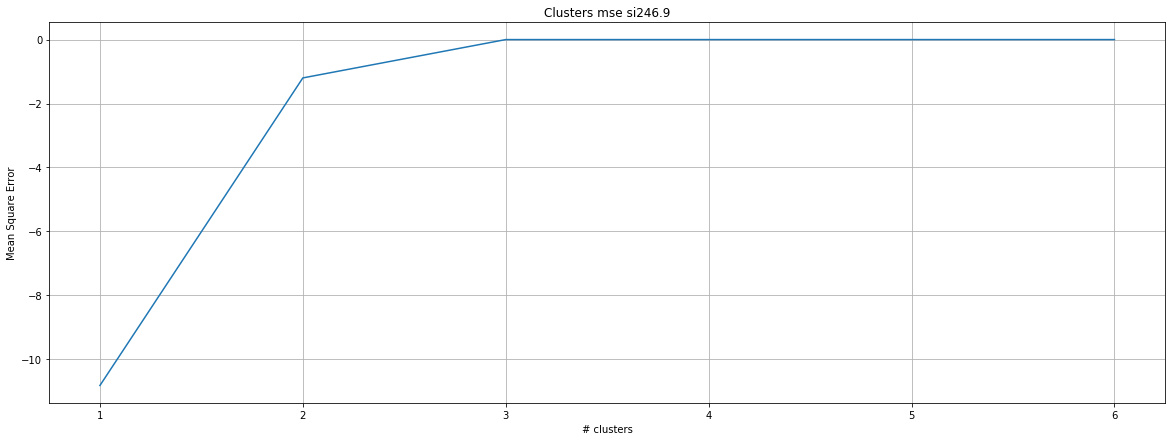

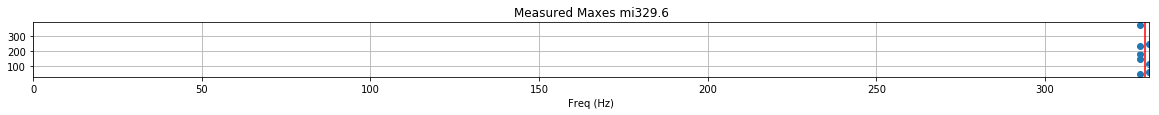

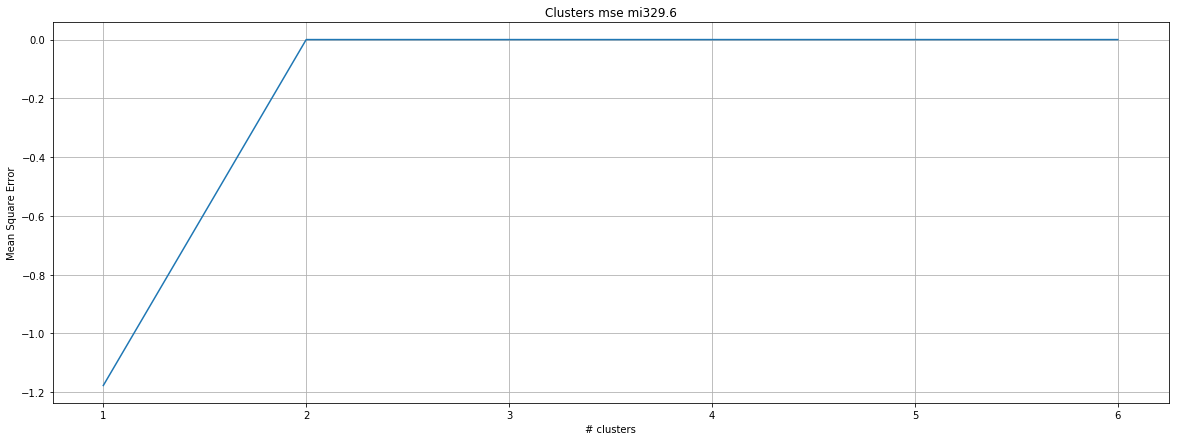

In [6]:
warnings.filterwarnings('ignore')

N_CLUSTERS_MAX = 6
AMP = 10
for fourier, freq, sound in zip(fourier_samples, frequencies, SOUNDS):
    # Here filter the smallest values
    # for some reason kmeans does not work with np.masks
    loudest = np.max(fourier)
    maxes = np.array([(freq[np.argmax(amp)], np.max(amp)) for amp in fourier if np.max(amp) > loudest / AMP])
    
    distortion = np.zeros(N_CLUSTERS_MAX)
    shaped_maxes = maxes.T[0].reshape(-1, 1)
    
    for n_clusters in range(1, N_CLUSTERS_MAX + 1):
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=0
        ).fit(shaped_maxes)
        centers = kmeans.cluster_centers_
        
        clusters_distortion = np.zeros(n_clusters)
        for i in range(n_clusters):
            mask = np.ma.masked_where(kmeans.labels_ != i, maxes.T[0])
            clusters_distortion[i] = mask.std() or 0
        distortion[n_clusters-1] = sum(clusters_distortion)
        
    matplotlib.rcParams['figure.figsize'] = (20.0, 1.0)
    plt.scatter(
        x=maxes.T[0],
        y=maxes.T[1],
    )
    plt.axvline(x=sound[1], color="red")
    M = 2
    while max(maxes.T[0])*1.1 > sound[1]*M:
        plt.axvline(x=sound[1]*M, color="orange")
        M += 1
    plt.xlabel("Freq (Hz)")
    plt.title(f"Measured Maxes {sound[0]}")
    plt.xlim(xmin=0)
    plt.grid()
    plt.show()
    
    matplotlib.rcParams['figure.figsize'] = (20.0, 7.0)
    plt.plot(
        np.linspace(1, N_CLUSTERS_MAX, N_CLUSTERS_MAX),
        -distortion,
    )
    
    plt.xlabel("# clusters")
    plt.ylabel("Mean Square Error")
    plt.title(f"Clusters mse {sound[0]}")
    plt.grid()
    plt.show()

warnings.filterwarnings('default')

We can see from the previous experiment that the determination of the number cluster is quite complicated. However if we filter out the points with a small amplitude there are nearly simply 2 or 3 clusters. For the rest of the experiment we will only work with 2 clusters and eliminate the points that are too far from the center.

## Test: Using centers as estimators

N clusters = 2

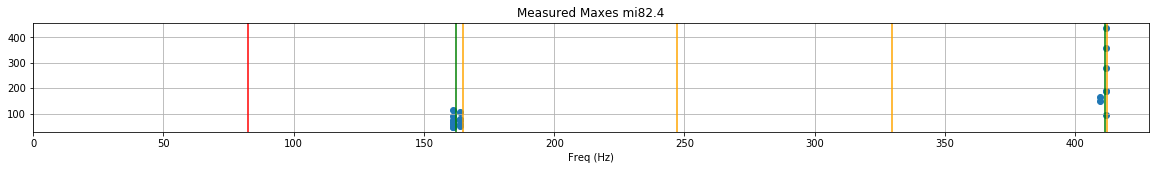

[[162.319982  ]
 [411.20471422]]
[[162.319982  ]
 [411.20471422]]
411.20471422142214 14


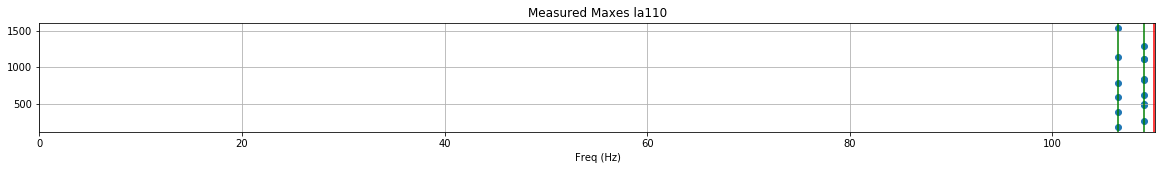

[[106.52173913]
 [108.99898888]]
[[106.52173913]
 [108.99898888]]
108.9989888776542 9


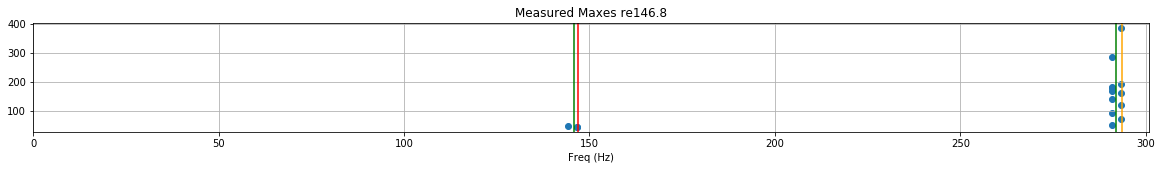

[[145.89155023]
 [291.98685961]]
[[145.89155023]
 [291.98685961]]
291.98685961410513 0


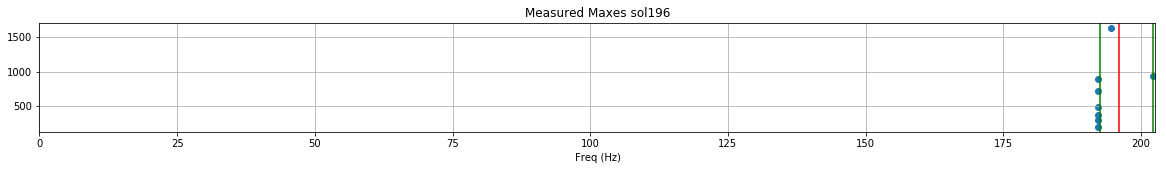

[[192.50792214]
 [202.13331824]]
[[192.50792214]
 [202.13331824]]
202.13331824354913 0


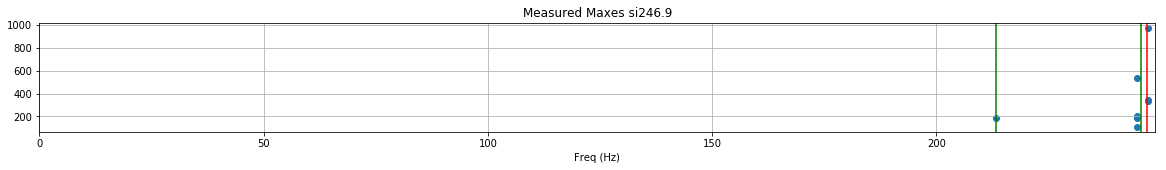

[[245.71522742]
 [213.18391562]]
[[245.71522742]
 [213.18391562]]
213.18391562294002 0


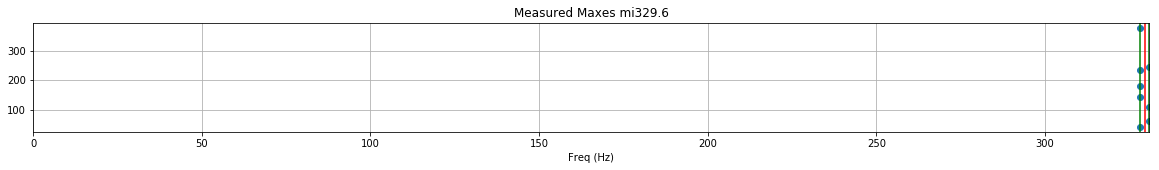

[[328.30594463]
 [330.73784052]]
[[328.30594463]
 [330.73784052]]
330.7378405205691 0


In [7]:
matplotlib.rcParams['figure.figsize'] = (20.0, 2.0)

N_CLUSTERS = 2
AMP = 10

MEASURED_NOTES = np.zeros(len(SOUNDS))

for i, fourier, freq, sound in zip(range(len(SOUNDS)), fourier_samples, frequencies, SOUNDS):
    # Here filter the smallest values
    # for some reason kmeans does not work with np.masks
    loudest = np.max(fourier)
    maxes = np.array([(freq[np.argmax(amp)], np.max(amp)) for amp in fourier if np.max(amp) > loudest / AMP])

    distortion = np.zeros(N_CLUSTERS)
    shaped_maxes = maxes.T[0].reshape(-1, 1)

    kmeans = KMeans(
            n_clusters=N_CLUSTERS,
            random_state=0
        ).fit(shaped_maxes)
    centers = kmeans.cluster_centers_


    plt.scatter(
        x=maxes.T[0],
        y=maxes.T[1],
    )
    plt.axvline(x=sound[1], color="red")
    M = 2
    while max(maxes.T[0])*1.1 > sound[1]*M:
        plt.axvline(x=sound[1]*M, color="orange")
        M += 1
    for center in centers:
        plt.axvline(x=center, color="green")
    plt.xlabel("Freq (Hz)")
    plt.title(f"Measured Maxes {sound[0]}")
    plt.xlim(left=0)
    plt.grid()
    plt.show()

    arg_center_with_max_points = 0
    max_points = 0
    for j in range(len(centers)):
        mask = np.ma.masked_where(kmeans.labels_ != i, maxes.T[0])
        print(centers)
        if mask.count() > max_points:
            arg_center_with_max_points = j
            max_points = mask.count()
    print(center[arg_center_with_max_points], max_points)
    MEASURED_NOTES[i] = centers[arg_center_with_max_points]

In [8]:
square_error = 0
for note, (f, e, _) in zip (MEASURED_NOTES, SOUNDS):
    square_error += ((e - note)/e) ** 2
    # print(f"Average for {note}:")
    print(f"Measured note: {note:.2f}Hz")
    print(f"Expected note: {e:.2f}Hz")
    print(f"Diff:          {e - note:.2f}Hz")
    print(f"%:             {(e - note)/e*100:.2f}%")
    print(f" ")

mean_square_error = square_error/len(SOUNDS)
print(f"MSE: {mean_square_error*100:.2f}%")

Measured note: 162.32Hz
Expected note: 82.41Hz
Diff:          -79.91Hz
%:             -96.97%
 
Measured note: 106.52Hz
Expected note: 110.00Hz
Diff:          3.48Hz
%:             3.16%
 
Measured note: 145.89Hz
Expected note: 146.80Hz
Diff:          0.91Hz
%:             0.62%
 
Measured note: 192.51Hz
Expected note: 196.00Hz
Diff:          3.49Hz
%:             1.78%
 
Measured note: 245.72Hz
Expected note: 246.90Hz
Diff:          1.18Hz
%:             0.48%
 
Measured note: 328.31Hz
Expected note: 329.60Hz
Diff:          1.29Hz
%:             0.39%
 
MSE: 15.69%


This is a much better result that the last experiment. However the precision is lower for some notes because there should be only one cluster. We should merge clusters that are close together. Maybee k-means is not really suited for that, we should give a try with k-medians.


## TODO 
- Create an estimator for harmonics we should classify the signals for that 
- Merge centroids that are too close, we do not take into account the quantizationn
- Create a new experiment with regard to time (do not study a 30 sec audio, but series of 500ms or 1sec with or without 


## TODO Later on
- "Gratage de note" detection to know when to start to listen
- Improve precision using harmonics and higher local maximuns

## Improvement 1: merge centroids

## Improvement 2: assuming the measured note is known to use harmonics